# Implementing a new plot

We'll show you how to implement a new plot using the nxviz's layered API.

As an example, we'll show you how the design process works
for the matrix plot.

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

## Example graph

As always, we'll need an example graph to anchor our notebook.

In [2]:
from random import choice

import networkx as nx
import numpy as np

G = nx.erdos_renyi_graph(n=20, p=0.1)
for n, d in G.nodes(data=True):
    G.nodes[n]["group"] = choice(["a", "b", "c"])
    G.nodes[n]["value"] = np.random.exponential()

np.random.seed(44)
for u, v, d in G.edges(data=True):
    G.edges[u, v]["edge_value"] = np.random.exponential()

## Implement node layout

We first have to worry about how the nodes are placed.
Therefore, we need a node layout function.

All node layout functions accept the following arguments:

- a node table `nt`,
- the key to `group_by`
- the key to `sort_by` (optionally)
- any other relevant keyword arguments

With the matrix plot layout,
from thinking about how the nodes should be laid out,
we will probably arrive at the conclusion
that grouping and sorting are technically optional
and not intrinsic to the layout.
If that's not obvious at first glance,
please think about it, you'll probably arrive at the same conclusion!

They then return the x, y coordinates to place nodes on.

The exact glyphs and their styles are out-of-bounds!
Therefore, don't worry about them just yet.

In [3]:
from typing import Hashable

import pandas as pd

from nxviz.utils import group_and_sort


# Just the skeleton first!
def matrix_layout(
    nt: pd.DataFrame, group_by: Hashable = None, sort_by: Hashable = None
):
    nt = group_and_sort(nt=nt, group_by=group_by, sort_by=sort_by)

With a matrix plot, our goal is to place nodes along the x- and y-axis.
It's a bit like the hive plot with cloned axes.

See the code annotations for the logic.

In [4]:
# Filling in the x,y positions dictionary.
def matrix_layout(
    nt: pd.DataFrame,
    group_by: Hashable = None,
    sort_by: Hashable = None,
    axis="x",
):
    # Nodes should be grouped and sorted before we begin assigning coordinates.
    nt = group_and_sort(node_table=nt, group_by=group_by, sort_by=sort_by)

    # We are eventually going to return this pos dictionary.
    pos = dict()

    # Loop over each of the rows, and assign x, y coordinates in order of them being grouped and sorted.
    for i, (node, data) in enumerate(nt.iterrows()):
        x = (i + 1) * 2
        y = 0

        if axis == "y":
            x, y = y, x
        pos[node] = np.array([x, y])
    return pos

Now that we have the positions implemented, let's see what they look like.

In [5]:
from nxviz import layouts
from nxviz.utils import node_table

nt = node_table(G)
pos_x = matrix_layout(nt, group_by="group", sort_by="value")
pos_y = matrix_layout(nt, group_by="group", sort_by="value", axis="y")

In [6]:
pd.DataFrame(pos_x).T

,0,1
16,2,0
4,4,0
17,6,0
5,8,0
10,10,0
14,12,0
8,14,0
11,16,0
3,18,0
0,20,0


In [7]:
pd.DataFrame(pos_y).T

,0,1
16,0,2
4,0,4
17,0,6
5,0,8
10,0,10
14,0,12
8,0,14
11,0,16
3,0,18
0,0,20


Now, we can worry about the glyphs being drawn to screen.
We will follow the logic for the mid-level API.
There is a `draw` function that we can take advantage of
to make it happen.

In [8]:
from functools import partial

from nxviz import nodes

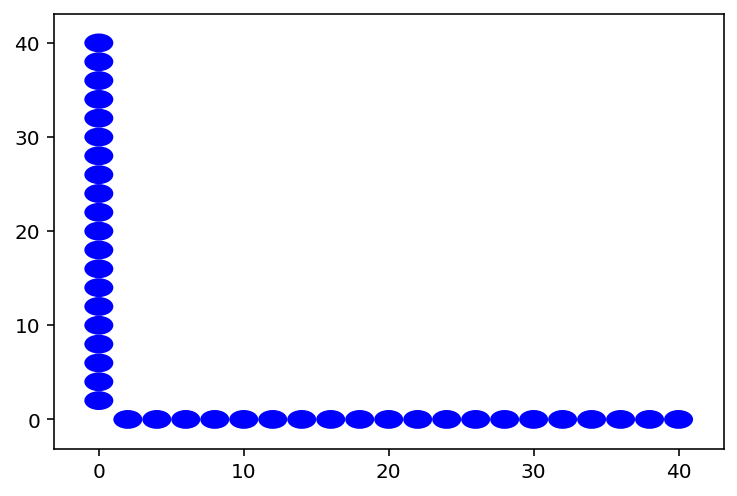

In [9]:
matrix = partial(
    nodes.draw, layout_func=matrix_layout, group_by=None, sort_by=None
)
pos_x = matrix(G)
pos_y = matrix(G, layout_kwargs=dict(axis="y"))

Not bad! We're off to a good start.
This looks ugly, but upon inspection, its' because the aspect ratio isn't that good.
We can fix this.

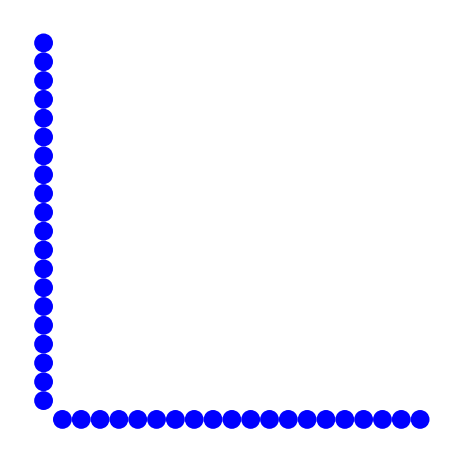

In [10]:
from nxviz.plots import aspect_equal, despine

matrix = partial(
    nodes.draw, layout_func=matrix_layout, group_by=None, sort_by=None
)
pos_x = matrix(G)
pos_y = matrix(G, layout_kwargs=dict(axis="y"))

aspect_equal()
despine()

Now that's looking good! We have a square matrix, just as we expected.

## Drawing edges

For edges, we could take advantage of hive plot's lines.
That would make the chart look interesting...
like one of those arts and crafts tapestries we might have made when we were younger.

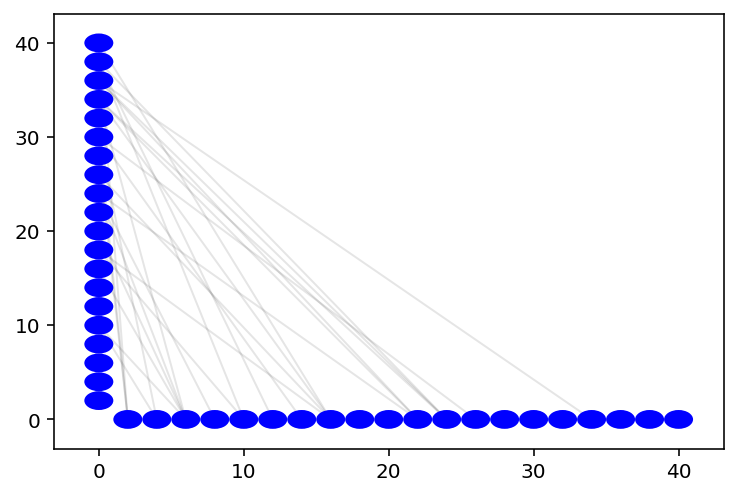

In [11]:
from nxviz import edges

matrix = partial(
    nodes.draw, layout_func=matrix_layout, group_by=None, sort_by=None
)
pos_x = matrix(G)
pos_y = matrix(G, layout_kwargs=dict(axis="y"))
edges.hive(G, pos_x, pos_cloned=pos_y, curves=False)

However, the spirit of a matrix plot is to fill in an `n-by-n` matrix.
Thus, we should actually be using a custom implementation of edges
that draws in a circle glyph where needed.

The matrix "lines" function will follow the API of the functions in the `nxviz.lines` file.
Lines are in quotes because we're not technically writing out lines. :)

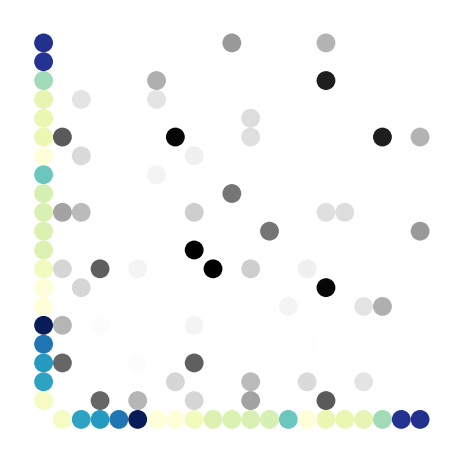

In [12]:
from typing import Dict, Iterable

from matplotlib.patches import Circle


def matrix_lines(
    et,
    pos,
    pos_cloned,
    directed,
    edge_color: Iterable,
    alpha: Iterable,
    lw: Iterable,
    aes_kw: Dict,
):
    patches = []
    for r, d in et.iterrows():
        start = d["source"]
        end = d["target"]
        x_start, y_start = pos_y[start]
        x_end, y_end = pos[end]

        x, y = (max(x_start, y_start), max(x_end, y_end))
        kw = {
            "fc": edge_color[r],
            "alpha": alpha[r],
            "radius": lw[r],
            "zorder": 10,
        }
        kw.update(aes_kw)
        patch = Circle(xy=(x, y), **kw)
        patches.append(patch)

        # In the mid-level API, we will need to explicitly set this.
        # In the high-level API, it's automatically inferred.
        if not directed:
            patch = Circle(xy=(y, x), **kw)
            patches.append(patch)
    return patches


matrix_edges = partial(
    edges.draw, lines_func=matrix_lines, aesthetics_kwargs={"alpha_scale": 10}
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
pos_x = matrix(G, group_by="group", color_by="value", sort_by="value")
pos_y = matrix(
    G,
    group_by="group",
    color_by="value",
    sort_by="value",
    layout_kwargs=dict(axis="y"),
)
edges.matrix(G, pos_x, pos_cloned=pos_y, alpha_by="edge_value", directed=False)

despine()
aspect_equal()

## Annotations

We may wish to annotate the plot with additional information.
For example, we might want to annotate the node values.
This is doable using the same annotation tools available to us in nxviz.

### Node color by group

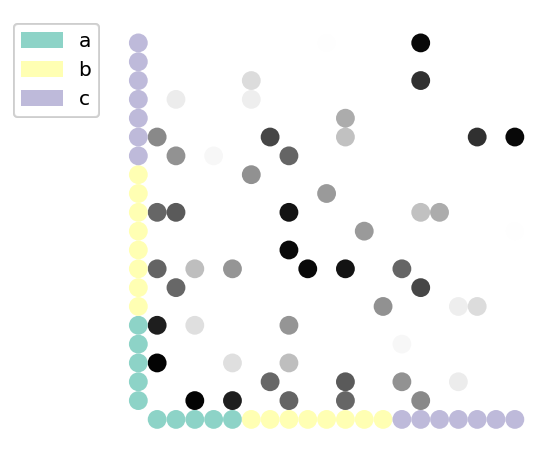

In [13]:
from nxviz import annotate

fig, ax = plt.subplots(figsize=(4, 4))
pos_x = matrix(G, group_by="group", color_by="group", sort_by="value")
pos_y = matrix(
    G,
    group_by="group",
    color_by="group",
    sort_by="value",
    layout_kwargs=dict(axis="y"),
)
matrix_edges(G, pos_x, pos_cloned=pos_y, alpha_by="edge_value", directed=False)

# Gives us a colorbar next to the chart.
annotate.node_colormapping(G, color_by="group")

despine()
aspect_equal()

### Node color by value

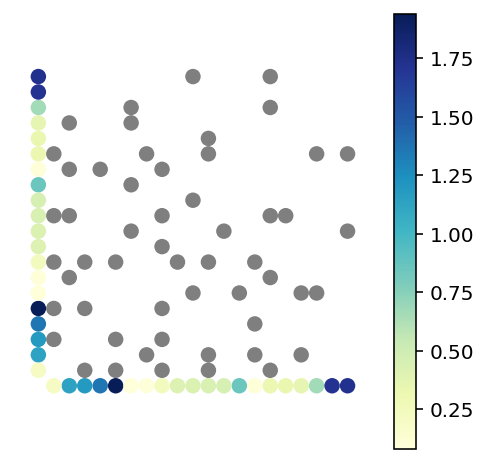

In [14]:
from nxviz import annotate

fig, ax = plt.subplots(figsize=(4, 4))
pos_x = matrix(G, group_by="group", color_by="value", sort_by="value")
pos_y = matrix(
    G,
    group_by="group",
    color_by="value",
    sort_by="value",
    layout_kwargs=dict(axis="y"),
)
matrix_edges(
    G, pos_x, pos_cloned=pos_y, directed=False, aesthetics_kwargs={"alpha_scale": 5}
)

# Gives us a colorbar next to the chart.
annotate.node_colormapping(G, color_by="value")

despine()
aspect_equal()

### Annotating group identity

The group identities can also be annotated on the chart itself.
Here's how the `matrix_group` annotation function is implemented.

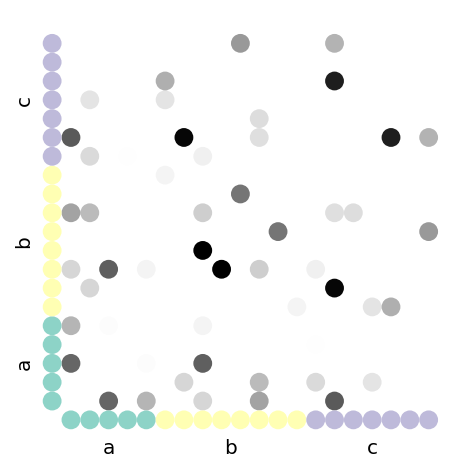

In [15]:
from nxviz.plots import respine


def matrix_group(G, group_by, ax=None, offset=-3.0, xrotation=0, yrotation=0):
    if ax is None:
        ax = plt.gca()
    nt = node_table(G)
    group_sizes = nt.groupby(group_by).apply(lambda df: len(df))
    proportions = group_sizes / group_sizes.sum()
    midpoint = proportions / 2
    starting_positions = proportions.cumsum() - proportions
    label_positions = (starting_positions + midpoint) * len(G) * 2
    label_positions += 1

    for label, position in label_positions.to_dict().items():
        # Plot the x-axis labels
        y = offset
        x = position
        ax.annotate(label, xy=(x, y), ha="center", va="center", rotation=0)

        # Plot the y-axis labels
        x = offset
        y = position
        ax.annotate(label, xy=(x, y), ha="center", va="center", rotation=90)


fig, ax = plt.subplots(figsize=(4, 4))
pos_x = matrix(G, group_by="group", color_by="group", sort_by="value")
pos_y = matrix(
    G,
    group_by="group",
    color_by="group",
    sort_by="value",
    layout_kwargs=dict(axis="y"),
)
matrix_edges(G, pos_x, pos_cloned=pos_y, alpha_by="edge_value", directed=False)

# Gives us a colorbar next to the chart.
matrix_group(G, group_by="group")

despine()
aspect_equal()

### Annotate matrix blocks

We could also annotate the matrix blocks using the exact same logic.

Matrix blocks are defined as the blocks of nodes in the same group,
so this only applies to graphs for which the nodes can be grouped together.

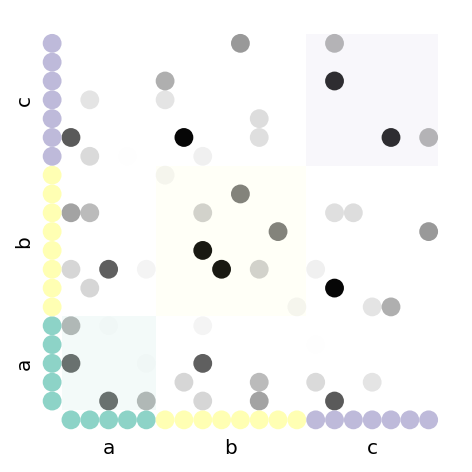

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
pos_x = matrix(G, group_by="group", color_by="group", sort_by="value")
pos_y = matrix(
    G,
    group_by="group",
    color_by="group",
    sort_by="value",
    layout_kwargs=dict(axis="y"),
)
matrix_edges(G, pos_x, pos_cloned=pos_y, alpha_by="edge_value", directed=False)

matrix_group(G, group_by="group")

respine()
aspect_equal()

##### FUNCTION STARTS

from matplotlib.patches import Rectangle

from nxviz import aesthetics as aes
from nxviz import utils

nt = node_table(G)
group_by = "group"
color_by = "group"


def matrix_block(G, group_by, color_by=None, ax=None):

    group_sizes = nt.groupby(group_by).apply(lambda df: len(df)) * 2
    starting_positions = group_sizes.cumsum() + 1 - group_sizes
    starting_positions

    colors = pd.Series(["black"] * len(group_sizes), index=group_sizes.index)
    if color_by:
        color_data = pd.Series(group_sizes.index, index=group_sizes.index)
        colors = aes.data_color(color_data)
    # Generate patches first
    patches = []
    for label, position in starting_positions.to_dict().items():
        xy = (position, position)
        width = height = group_sizes[label]

        patch = Rectangle(
            xy, width, height, zorder=0, alpha=0.1, facecolor=colors[label]
        )
        patches.append(patch)

    if ax is None:
        ax = plt.gca()
    # Then add patches in.
    for patch in patches:
        ax.add_patch(patch)


matrix_block(G, group_by=group_by, color_by=color_by)
##### FUNCTION ENDS
despine()

## High level API

Of course, in showing you how to implement a matrix plot from scratch,
we took the code and shoved it into our high-level API.
Here's a few examples of how it's used.

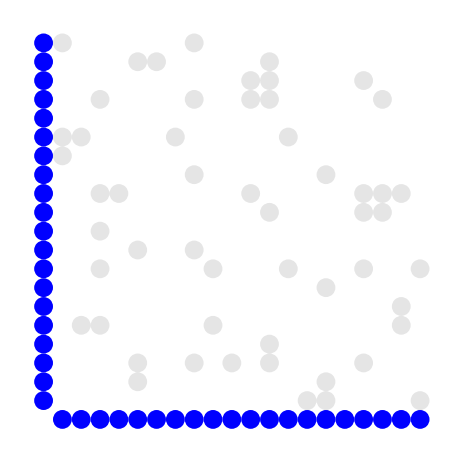

In [17]:
import nxviz as nv

ax = nv.matrix(G)

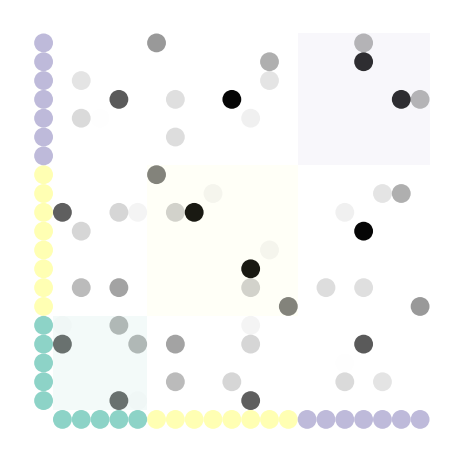

In [18]:
ax = nv.matrix(
    G, group_by="group", node_color_by="group", edge_alpha_by="edge_value"
)
annotate.matrix_block(G, group_by="group", color_by="group")